In [30]:
import pandas as pd
import numpy as np
import ast
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder, StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix

In [31]:
columns_dtype = {
    'flow_id': 'string',
    'timestamp': 'string',  # parse as datetime later
    'src_ip': 'string',
    'src_port': 'Int64',
    'dst_ip': 'string',
    'dst_port': 'Int64',
    'protocol': 'string',
    'duration': 'float',
    'packets_numbers': 'Int64',
    'receiving_packets_numbers': 'Int64',
    'sending_packets_numbers': 'Int64',
    'handshake_duration': 'string',
    'delta_start': 'string',
    'total_bytes': 'Int64',
    'receiving_bytes': 'Int64',
    'sending_bytes': 'Int64',
    'packets_rate': 'float',
    'receiving_packets_rate': 'float',
    'sending_packets_rate': 'float',
    'packets_len_rate': 'float',
    'receiving_packets_len_rate': 'float',
    'sending_packets_len_rate': 'float',
    'min_packets_len': 'Int64',
    'max_packets_len': 'Int64',
    'mean_packets_len': 'float',
    'median_packets_len': 'float',
    'mode_packets_len': 'float',
    'standard_deviation_packets_len': 'float',
    'variance_packets_len': 'float',
    'coefficient_of_variation_packets_len': 'float',
    'skewness_packets_len': 'float',
    'min_receiving_packets_len': 'Int64',
    'max_receiving_packets_len': 'Int64',
    'mean_receiving_packets_len': 'float',
    'median_receiving_packets_len': 'float',
    'mode_receiving_packets_len': 'float',
    'standard_deviation_receiving_packets_len': 'float',
    'variance_receiving_packets_len': 'float',
    'coefficient_of_variation_receiving_packets_len': 'float',
    'skewness_receiving_packets_len': 'float',
    'min_sending_packets_len': 'Int64',
    'max_sending_packets_len': 'Int64',
    'mean_sending_packets_len': 'float',
    'median_sending_packets_len': 'float',
    'mode_sending_packets_len': 'float',
    'standard_deviation_sending_packets_len': 'float',
    'variance_sending_packets_len': 'float',
    'coefficient_of_variation_sending_packets_len': 'float',
    'skewness_sending_packets_len': 'float',
    'min_receiving_packets_delta_len': 'Int64',
    'max_receiving_packets_delta_len': 'Int64',
    'mean_receiving_packets_delta_len': 'float',
    'median_receiving_packets_delta_len': 'float',
    'standard_deviation_receiving_packets_delta_len': 'float',
    'variance_receiving_packets_delta_len': 'float',
    'mode_receiving_packets_delta_len': 'float',
    'coefficient_of_variation_receiving_packets_delta_len': 'float',
    'skewness_receiving_packets_delta_len': 'float',
    'min_sending_packets_delta_len': 'Int64',
    'max_sending_packets_delta_len': 'Int64',
    'mean_sending_packets_delta_len': 'float',
    'median_sending_packets_delta_len': 'float',
    'standard_deviation_sending_packets_delta_len': 'float',
    'variance_sending_packets_delta_len': 'float',
    'mode_sending_packets_delta_len': 'float',
    'coefficient_of_variation_sending_packets_delta_len': 'float',
    'skewness_sending_packets_delta_len': 'float',
    'max_receiving_packets_delta_time': 'float',
    'mean_receiving_packets_delta_time': 'float',
    'median_receiving_packets_delta_time': 'float',
    'standard_deviation_receiving_packets_delta_time': 'float',
    'variance_receiving_packets_delta_time': 'float',
    'mode_receiving_packets_delta_time': 'float',
    'coefficient_of_variation_receiving_packets_delta_time': 'float',
    'skewness_sreceiving_packets_delta_time': 'float',
    'min_sending_packets_delta_time': 'float',
    'max_sending_packets_delta_time': 'float',
    'mean_sending_packets_delta_time': 'float',
    'median_sending_packets_delta_time': 'float',
    'standard_deviation_sending_packets_delta_time': 'float',
    'variance_sending_packets_delta_time': 'float',
    'mode_sending_packets_delta_time': 'float',
    'coefficient_of_variation_sending_packets_delta_time': 'float',
    'skewness_sending_packets_delta_time': 'float',
    'dns_domain_name': 'string',
    'dns_top_level_domain': 'string',
    'dns_second_level_domain': 'string',
    'dns_domain_name_length': 'Int64',
    'dns_subdomain_name_length': 'Int64',
    'uni_gram_domain_name': 'string',
    'bi_gram_domain_name': 'string',
    'tri_gram_domain_name': 'string',
    'numerical_percentage': 'float',
    'character_distribution': 'string',
    'character_entropy': 'float',
    'max_continuous_numeric_len': 'Int64',
    'max_continuous_alphabet_len': 'Int64',
    'max_continuous_consonants_len': 'Int64',
    'max_continuous_same_alphabet_len': 'Int64',
    'vowels_consonant_ratio': 'float',
    'conv_freq_vowels_consonants': 'float',
    'distinct_ttl_values': 'Int64',
    'ttl_values_min': 'Int64',
    'ttl_values_max': 'Int64',
    'ttl_values_mean': 'float',
    'ttl_values_mode': 'float',
    'ttl_values_variance': 'float',
    'ttl_values_standard_deviation': 'float',
    'ttl_values_median': 'float',
    'ttl_values_skewness': 'float',
    'ttl_values_coefficient_of_variation': 'float',
    'distinct_A_records': 'Int64',
    'distinct_NS_records': 'Int64',
    'average_authority_resource_records': 'float',
    'average_additional_resource_records': 'float',
    'average_answer_resource_records': 'float',
    'query_resource_record_type': 'string',
    'ans_resource_record_type': 'string',
    'query_resource_record_class': 'string',
    'ans_resource_record_class': 'string',
    'label': 'string'
}

In [32]:
benign_df = pd.read_csv('../benign.csv', dtype=columns_dtype, low_memory=False)
phishing_df = pd.read_csv('../phishing.csv', dtype=columns_dtype, low_memory=False)
spam_df = pd.read_csv('../spam.csv', dtype=columns_dtype, low_memory=False)
malware_df = pd.read_csv('../malware.csv', dtype=columns_dtype, low_memory=False)

benign_df = benign_df.head(10000)
phishing_df = phishing_df.head(10000)
spam_df = spam_df.head(10000)
malware_df = malware_df.head(10000)

print("Benign:", benign_df.shape)
print("Phishing:", phishing_df.shape)
print("Spam:", spam_df.shape)
print("Malware:", malware_df.shape)

data = pd.concat([benign_df, phishing_df, spam_df, malware_df], ignore_index=True)
print("Combined dataset shape:", data.shape)

Benign: (10000, 122)
Phishing: (10000, 122)
Spam: (10000, 122)
Malware: (10000, 122)
Combined dataset shape: (40000, 122)


In [73]:
missing_vals = data.isnull().sum()
missing_pct = (missing_vals / len(data)) * 100
print("Missing Values (%):", missing_pct[missing_pct > 0])

data_cleaned = data.drop('dns_subdomain_name_length', axis=1)

# Parse timestamp
data_cleaned['timestamp'] = pd.to_datetime(data_cleaned['timestamp'], errors='coerce')
data_cleaned = data_cleaned.dropna(subset=['timestamp'])
# Sort by timestamp only
data_cleaned = data_cleaned.sort_values('timestamp').reset_index(drop=True)
print("\nData sorted by timestamp.")

Missing Values (%): coefficient_of_variation_receiving_packets_delta_len     0.3875
coefficient_of_variation_sending_packets_delta_len       0.3725
dns_subdomain_name_length                               94.6300
ttl_values_coefficient_of_variation                      0.0900
dtype: float64

Data sorted by timestamp.


In [74]:
le_label = LabelEncoder()
data_cleaned['label_encoded'] = le_label.fit_transform(data_cleaned['label'])
print("Label classes:", le_label.classes_)

Label classes: ['Benign' 'Malware' 'Phishing' 'Spam']


In [75]:
essential_features = [
    'timestamp',
    'dns_top_level_domain',
    'dns_second_level_domain',
    'dns_domain_name_length',
    'uni_gram_domain_name',
    'bi_gram_domain_name',
    'tri_gram_domain_name',
    'numerical_percentage',
    'character_entropy',
    'max_continuous_numeric_len',
    'max_continuous_alphabet_len',
    'vowels_consonant_ratio',
    'conv_freq_vowels_consonants',
    'query_resource_record_type',
    'ans_resource_record_type',
    'query_resource_record_class',
    'ans_resource_record_class',
    'packets_numbers',
    'receiving_packets_numbers',
    'sending_packets_numbers',
    'receiving_bytes',
    'sending_bytes',
    'distinct_ttl_values',
    'ttl_values_min',
    'ttl_values_max',
    'ttl_values_mean',
    'character_distribution',
    'label_encoded'
]

data_selected = data_cleaned[essential_features].copy()
print("Selected shape:", data_selected.shape)

Selected shape: (40000, 28)


In [76]:
placeholder = 'unknown'
data_selected['dns_top_level_domain'] = data_selected['dns_top_level_domain'].fillna(placeholder)
data_selected['dns_second_level_domain'] = data_selected['dns_second_level_domain'].fillna(placeholder)

all_tld = data_selected['dns_top_level_domain'].unique().tolist()
if 'unknown' not in all_tld:
    all_tld.append('unknown')

all_sld = data_selected['dns_second_level_domain'].unique().tolist()
if 'unknown' not in all_sld:
    all_sld.append('unknown')

le_tld = LabelEncoder()
le_sld = LabelEncoder()
le_tld.fit(all_tld)
le_sld.fit(all_sld)

data_selected['dns_top_level_domain'] = data_selected['dns_top_level_domain'].apply(
    lambda x: x if x in all_tld else 'unknown'
)
data_selected['dns_second_level_domain'] = data_selected['dns_second_level_domain'].apply(
    lambda x: x if x in all_sld else 'unknown'
)

data_selected['dns_top_level_domain_encoded'] = le_tld.transform(data_selected['dns_top_level_domain'])
data_selected['dns_second_level_domain_encoded'] = le_sld.transform(data_selected['dns_second_level_domain'])

data_selected.drop(['dns_top_level_domain','dns_second_level_domain'], axis=1, inplace=True)

In [77]:
def parse_list_safe(list_entry):
    if isinstance(list_entry, list):
        return list_entry
    elif isinstance(list_entry, str):
        try:
            return ast.literal_eval(list_entry)
        except (ValueError, SyntaxError):
            return []
    else:
        return []

ngram_cols = ['uni_gram_domain_name','bi_gram_domain_name','tri_gram_domain_name']
for col in ngram_cols:
    data_selected[col] = data_selected[col].apply(parse_list_safe)

count_cols = ['uni_gram_count','bi_gram_count','tri_gram_count']
for ncol, ccol in zip(ngram_cols, count_cols):
    data_selected[ccol] = data_selected[ncol].apply(len)

data_selected.drop(ngram_cols, axis=1, inplace=True)
print("Created n-gram counts, dropped original n-gram columns.")

Created n-gram counts, dropped original n-gram columns.


In [78]:
record_cols = [
    'query_resource_record_type',
    'ans_resource_record_type',
    'query_resource_record_class',
    'ans_resource_record_class'
]
for rcol in record_cols:
    data_selected[rcol] = data_selected[rcol].apply(parse_list_safe)
    ccount = f"{rcol}_count"
    data_selected[ccount] = data_selected[rcol].apply(lambda x: len(set(x)) if isinstance(x,list) else 0)

data_selected.drop(record_cols, axis=1, inplace=True)
print("Processed resource record columns.")

Processed resource record columns.


In [79]:
vowels = set('aeiou')
consonants = set('bcdfghjklmnpqrstvwxyz')

def extract_vowels_consonants(dist):
    vowel_count = 0
    consonant_count = 0
    if isinstance(dist, str):
        try:
            dist = ast.literal_eval(dist)
        except (ValueError, SyntaxError):
            dist = {}
    if isinstance(dist, dict):
        for ch, c in dist.items():
            if ch in vowels:
                vowel_count += c
            elif ch in consonants:
                consonant_count += c
    return pd.Series({'vowel_count': vowel_count, 'consonant_count': consonant_count})

char_dist_feats = data_selected['character_distribution'].apply(extract_vowels_consonants)
data_selected = pd.concat([data_selected, char_dist_feats], axis=1)
data_selected.drop('character_distribution', axis=1, inplace=True)
print("Extracted vowel_count/consonant_count from 'character_distribution'.")

Extracted vowel_count/consonant_count from 'character_distribution'.


In [80]:
X = data_selected.drop(['label_encoded'], axis=1)
y = data_selected['label_encoded']
print("X shape:", X.shape,"| y shape:", y.shape)

X shape: (40000, 28) | y shape: (40000,)


In [85]:
# Exclude 'timestamp' from scaling
ignore_cols = ['timestamp']
numeric_cols = [col for col in X.columns
                if (str(X[col].dtype) in ['Int64', 'int64','float64'] and col not in ignore_cols)]

numeric_cols = [col for col in X.columns
                if col not in ignore_cols]

scaler = StandardScaler()
scaler.fit(X[numeric_cols])

print(len(numeric_cols))

X_scaled = X.copy()
X_scaled[numeric_cols] = scaler.transform(X[numeric_cols])
print("Scaled numeric features.")

27
Scaled numeric features.


In [86]:
x_train_val, x_test, y_train_val, y_test = train_test_split(
    X_scaled, y, test_size=0.1, random_state=42, stratify=y
)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, test_size=0.1111, random_state=42, stratify=y_train_val
)

print("Train shape:", x_train.shape, y_train.shape)
print("Val shape:",   x_val.shape,   y_val.shape)
print("Test shape:",  x_test.shape,  y_test.shape)

Train shape: (32000, 28) (32000,)
Val shape: (4000, 28) (4000,)
Test shape: (4000, 28) (4000,)


In [87]:
def create_sequences_sorted(x_df, y_series, seq_len):
    combined = x_df.copy()
    combined['label_encoded'] = y_series.values

    # Sort by timestamp if available
    if 'timestamp' in combined.columns:
        combined = combined.sort_values('timestamp').reset_index(drop=True)

    # Drop timestamp + label from final input features
    final_x = combined.drop(['timestamp','label_encoded'], axis=1, errors='ignore')
    final_y = combined['label_encoded']

    # Ensure numeric type
    final_x = final_x.astype('float32', errors='ignore')  # or 'float64'

    X_seq, y_seq = [], []
    for i in range(len(final_x) - seq_len + 1):
        window_x = final_x.iloc[i:i+seq_len].values
        window_y = final_y.iloc[i+seq_len-1]
        X_seq.append(window_x)
        y_seq.append(window_y)

    return np.array(X_seq), np.array(y_seq)

sequence_length = 5

x_train_rnn, y_train_rnn = create_sequences_sorted(x_train, y_train, sequence_length)
x_val_rnn,   y_val_rnn   = create_sequences_sorted(x_val,   y_val,   sequence_length)
x_test_rnn,  y_test_rnn  = create_sequences_sorted(x_test,  y_test,  sequence_length)

print("x_train_rnn:", x_train_rnn.shape,"y_train_rnn:", y_train_rnn.shape)
print("x_val_rnn:",   x_val_rnn.shape,  "y_val_rnn:",   y_val_rnn.shape)
print("x_test_rnn:",  x_test_rnn.shape, "y_test_rnn:",  y_test_rnn.shape)

x_train_rnn: (31996, 5, 27) y_train_rnn: (31996,)
x_val_rnn: (3996, 5, 27) y_val_rnn: (3996,)
x_test_rnn: (3996, 5, 27) y_test_rnn: (3996,)


In [88]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_rnn),
    y=y_train_rnn
)
class_weights_dict = {i: w for i,w in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.000375187593797, 1: 0.999875, 2: 0.999875, 3: 0.999875}


In [89]:
num_classes = len(np.unique(y_train_rnn))

model = Sequential([
    Input(shape=(sequence_length, x_train_rnn.shape[2])),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional)      │ (None, 5, 256)              │         159,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 5, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 341,124 (1.30 MB)

 Trainable params: 341,124 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

In [90]:
x_train_rnn = x_train_rnn.astype('float32')
x_val_rnn   = x_val_rnn.astype('float32')
x_test_rnn  = x_test_rnn.astype('float32')

In [91]:
batch_size = 32
epochs = 50

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    x_train_rnn, y_train_rnn,
    validation_data=(x_val_rnn, y_val_rnn),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.6231 - loss: 0.9091 - val_accuracy: 0.8048 - val_loss: 0.5580 - learning_rate: 5.0000e-04
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7208 - loss: 0.6983 - val_accuracy: 0.8273 - val_loss: 0.5047 - learning_rate: 5.0000e-04
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7570 - loss: 0.6188 - val_accuracy: 0.8403 - val_loss: 0.4395 - learning_rate: 5.0000e-04
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7827 - loss: 0.5506 - val_accuracy: 0.8351 - val_loss: 0.4347 - learning_rate: 5.0000e-04
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8023 - loss: 0.5019 - val_accuracy: 0.8448 - val_loss: 0.4156 - learning_rate: 5.0000e-04
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8229 - loss: 0.4534 - val_accuracy: 0.8561 - val_loss: 0.3894 - learning_rate: 5.0000e-04
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/st


Test Loss: 0.3844
Test Accuracy: 0.8621
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Classification Report:
              precision    recall  f1-score   support

      Benign       0.89      0.90      0.89       996
     Malware       0.78      0.81      0.79      1000
    Phishing       0.86      0.84      0.85      1000
        Spam       0.93      0.91      0.92      1000

    accuracy                           0.86      3996
   macro avg       0.86      0.86      0.86      3996
weighted avg       0.86      0.86      0.86      3996



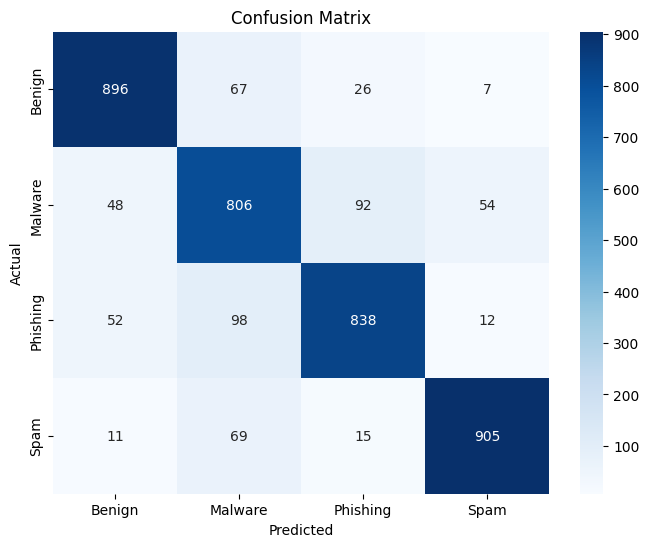

In [94]:
test_loss, test_acc = model.evaluate(x_test_rnn, y_test_rnn, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

y_pred_probs = model.predict(x_test_rnn)
y_pred = np.argmax(y_pred_probs, axis=1)

target_names = le_label.classes_  # e.g., ['Benign','Phishing','Spam','Malware']
print("\nClassification Report:")
print(classification_report(y_test_rnn, y_pred, target_names=target_names, zero_division=0))

conf_mat = confusion_matrix(y_test_rnn, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [95]:
model.save('dnshield_rnn_timestamp.h5')
print("Model saved to 'dnshield_rnn_timestamp.h5'.")

# Save label encoders, scaler
joblib.dump(le_label, 'label_encoder.pkl')
joblib.dump(le_tld, 'le_dns_top_level_domain.pkl')
joblib.dump(le_sld, 'le_dns_second_level_domain.pkl')
joblib.dump(scaler,  'scaler.pkl')
print("Saved label encoders and scaler.")

Model saved to 'dnshield_rnn_timestamp.h5'.
Saved label encoders and scaler.
